#  fMDCM from Trajectories

## need: 

geometry or angles, bond lengths

local charge positions


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_ridge import KernelRidge

from mlxtend.preprocessing import minmax_scaling
from scipy import stats

BOHR_TO_ANGSTROM = 0.529177

directory_path = "/home/boittier/FDCM/traj1000"

subdirs = [x for x in os.listdir(directory_path) if x.startswith(".") == False]

def get_geometry_from_cube(path):
    f = open(path)
    lines = f.readlines()
    a,b,c = lines[6:9]
    O = np.array([float(x) for x in a.split()[2:]])
    H1 = np.array([float(x) for x in b.split()[2:]])
    H2 = np.array([float(x) for x in c.split()[2:]])
    r2 = distance.euclidean(O, H1)*BOHR_TO_ANGSTROM
    r3 = distance.euclidean(O, H2)*BOHR_TO_ANGSTROM
    ba = H1 - O
    bc = H2 - O

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    a3 = np.degrees(np.arccos(cosine_angle))
    return O, H1, H2, r2, r3, a3

    
def get_local_charges(path):
    tmp_dict = {}
    local_file = open(path).readlines()
    n_lines = int(local_file[0])
    charges = local_file[2:n_lines+2]
    charges = np.array([ [float(x.split()[1]),
              float(x.split()[2]),
              float(x.split()[3]),
              float(x.split()[4])] for x in charges])

    for i, axis in enumerate(["x", "y", "z", "q"]):
        for c in range(n_lines):
            if f"{axis}_c{c}" not in tmp_dict.keys():
                tmp_dict[f"{axis}_c{c}"] = charges[c,i]
            
            
    return tmp_dict

def get_error(path):
    f = open(path)
    lines = f.readlines()
    total = lines[-5]
    total = float(total.split()[1])
    return total
    

/home/boittier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/boittier/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
data_dict = {"O": [], "H1": [], "H2": [], "r2": [], "r3": [], "a3": [], "total": []}
local_dicts = []

for subd in subdirs:
    p1 = os.path.join(directory_path, subd, "6charges.cube")
    O, H1, H2, r2, r3, a3 = get_geometry_from_cube(p1)
    total = get_error(os.path.join(directory_path, subd, "analysis.log"))
    data_dict["O"].append(O)
    data_dict["H1"].append(H1)
    data_dict["H2"].append(H2)
    data_dict["r2"].append(r2)
    data_dict["r3"].append(r3)
    data_dict["a3"].append(a3)
    data_dict["total"].append(total)
    
    local_file = [x for x in os.listdir(os.path.join(directory_path, subd)) if x.startswith("local")]
    
    local_dicts.append(get_local_charges(os.path.join(directory_path, subd, local_file[0])))

    
df = pd.DataFrame(data_dict)
local_df = pd.DataFrame(local_dicts)
local_df_xyz_keys = [x for x in list(local_df.keys()) if not x.startswith("q")]


In [ ]:
plt.scatter(df["a3"], df["total"])
plt.show()
plt.scatter(df["r3"], df["total"])
print(len(df))

In [220]:
complete_df = pd.concat([df, local_df], axis=1)
complete_df["a3"] = [float(x) for x in list(complete_df["a3"])]
complete_df["x_c0"] = [float(x) for x in list(complete_df["x_c0"])]

# sns.scatterplot(x="a3", y="x_c0", data=complete_df)

In [251]:
df["bond_sum"] = df["r2"] + df["r3"]
df["bond_sum_scaled"] = 
df["r2_scaled"] = df["r2"]
df["a3_scaled"] = df["a3"]/105.04


In [249]:
n_samples, n_features = 1001, 6*3

y = local_df[local_df_xyz_keys].values
X = df[["bond_sum", "a3"]].values
krr = KernelRidge(alpha=1.0)
krr.fit(X,y)

/home/boittier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

In [250]:
krr.score(X, y)

/home/boittier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


0.2584761570180665

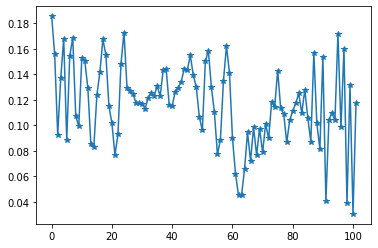

In [214]:
local_df[["x_c0", "y_c0", "z_c0"]]
key = "x_c1"
plt.plot(range(len(local_df[key])), local_df[key], "-*")

In [215]:
result = krr.predict(X)

/home/boittier/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [216]:
np.sqrt(np.array(y - result)**2)

array([[0.05425104, 0.0249643 , 0.02254322, ..., 0.10165545, 0.03470769,
        0.05598843],
       [0.01172688, 0.03179265, 0.04096973, ..., 0.05133387, 0.00014516,
        0.01212278],
       [0.0172834 , 0.0181858 , 0.02968713, ..., 0.02221736, 0.01155584,
        0.01832604],
       ...,
       [0.0117763 , 0.0185071 , 0.03314623, ..., 0.0188895 , 0.01935267,
        0.03295919],
       [0.02386192, 0.02822676, 0.01443912, ..., 0.04755088, 0.00374854,
        0.02151522],
       [0.02306743, 0.02997989, 0.04193639, ..., 0.02318154, 0.01948721,
        0.03230657]])

In [ ]:
result.shape